# 4 - Packed Padded Sequences, Masking, Inference and BLEU

## Introduction

In this notebook we will be adding a few improvements - packed padded sequences and masking - to the model from the previous notebook. Packed padded sequences are used to tell our RNN to skip over padding tokens in our encoder. Masking explicitly forces the model to ignore certain values, such as attention over padded elements. Both of these techniques are commonly used in NLP. 

We will also look at how to use our model for inference, by giving it a sentence, seeing what it translates it as and seeing where exactly it pays attention to when translating each word.

Finally, we'll use the BLEU metric to measure the quality of our translations.


## Install required libraries

We'll be coding up the models in PyTorch and using torchtext to help us do all of the pre-processing required. We'll also be using spaCy to assist in the tokenization of the data. Install spaCy tokenizers for English and German. 

In [1]:
!pip install -U torchdata
!pip install -U spacy
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm
!wget "http://www.quest.dcs.shef.ac.uk/wmt16_files_mmt/training.tar.gz"
!wget "http://www.quest.dcs.shef.ac.uk/wmt16_files_mmt/validation.tar.gz"
!wget "http://www.quest.dcs.shef.ac.uk/wmt16_files_mmt/mmt16_task1_test.tar.gz"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 5.2 MB/s 
     |████████████████████████████████| 140 kB 42.7 MB/s 
     |████████████████████████████████| 127 kB 67.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 5.1 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.6 MB 4.9 MB/s 
✔ Download and installation successful
You can now load

## Imports

Import evertyhing we need to train the model.

In [2]:
from typing import List, Iterable

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import multi30k, Multi30k

import spacy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import random
import math
import time

We'll set the random seeds for deterministic results.

In [3]:
SEED: int = 1234

def random_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.determenistic = True

random_seed(SEED)

The dataset we'll be using is the [Multi30k dataset](https://github.com/multi30k/dataset). This is a dataset with ~30,000 parallel English, German and French sentences, each with ~12 words per sentence. Currently, the URL for multi30k is broken so we have to replace with temporary links to download dataset. 

Next, we'll create the tokenizers. A tokenizer is used to turn a string containing a sentence into a list of individual tokens that make up that string, e.g. "good morning!" becomes ["good", "morning", "!"]. We'll start talking about the sentences being a sequence of tokens from now, instead of saying they're a sequence of words. What's the difference? Well, "good" and "morning" are both words and tokens, but "!" is a token, not a word. 

```
tokenizer_de = get_tokenizer("spacy", language="de_core_news_sm")
tokenizer_en = get_tokenizer("spacy", language="en_core_web_sm")
```
spaCy has model for each language ("de_core_news_sm" for German and "en_core_web_sm" for English) which need to be loaded so we can access the tokenizer of each model. 

In [4]:
SOURCE_LANGUAGE = 'de'
TARGET_LANGUAGE = 'en'

token_transform = {}
vocab_transform = {}

token_transform[SOURCE_LANGUAGE] = get_tokenizer("spacy", language="de_core_news_sm")
token_transform[TARGET_LANGUAGE] = get_tokenizer("spacy", language="en_core_web_sm")


def yield_tokens(data_iter: Iterable, language: str):
    language_index = {SOURCE_LANGUAGE: 0, TARGET_LANGUAGE: 1}
    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

Next, we'll build the *vocabulary* for the source and target languages. The vocabulary is used to associate each unique token with an index (an integer). The vocabularies of the source and target languages are distinct.

`torchtext`'s `build_vocab_from_iterator` would handle create of vocabulary for us. We have to set a yield fucntion for data processing where we will tokenize sentences. Add special tokens with their correspoding indexes with in the vocabulary.Using the `min_freq` argument, we only allow tokens that appear at least 2 times to appear in our vocabulary. Tokens that appear only once are converted into an `<unk>` (unknown) token. Special tokens: `<unk>` - unknown token which is not in the vocabulary, `<pad>` - padding token to make senteces equal lenght for dataloader, `<bos>` - begining of the sentence, `<eos>` - end of the sentence.   

It is important to note that our vocabulary should only be built from the training set and not the validation/test set. This prevents "information leakage" into our model, giving us artifically inflated validation/test scores.

In [5]:
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

In [6]:
for language in [SOURCE_LANGUAGE, TARGET_LANGUAGE]:
    train_iter = Multi30k(root="/content", split="train", language_pair=(SOURCE_LANGUAGE, TARGET_LANGUAGE))
    vocab_transform[language] = build_vocab_from_iterator(
        yield_tokens(train_iter, language),
        min_freq=2,
        specials=special_symbols,
        special_first=True
    )

for language in [SOURCE_LANGUAGE, TARGET_LANGUAGE]:
    vocab_transform[language].set_default_index(UNK_IDX)

We also need to define a `torch.device`. This is used to tell torchText to put the tensors on the GPU or not. We use the `torch.cuda.is_available()` function, which will return `True` if a GPU is detected on our computer. We pass this `device` to the iterator.


In [7]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Unlike previous version, `torchtext Field` did for us  tokenization and added special symbols, with current version of `torchtext>=0.12.0` you have to make a pipeline for text processing. `text_transform` is dictionary containg all necessary tranformation for source and target languages. Firsly, we tokenize sentences. Secondly, transform it into vocavulary indexes and add special symbol `<bos>` and `<eos>` for indication of start of senteces and ends. Finaly, transform it into `torch.Tensor`.

In [8]:
def sequential_transforms(*transforms):
    def func(text_input: str):
        for transform in transforms:
            text_input = transform(text_input)
        return text_input
    return func

def to_tensor(token_ids: List[int]):
    return torch.cat((
        torch.tensor([BOS_IDX]),
        torch.tensor(token_ids),
        torch.tensor([EOS_IDX]),
    ))

text_transform = {}

for language in [SOURCE_LANGUAGE, TARGET_LANGUAGE]:
    text_transform[language] = sequential_transforms(
        token_transform[language],  # Tokenization
        vocab_transform[language],  # Numericalization
        to_tensor  # Add BOS/EOS and create tensor
    )

def collate_fn(batch):
    source_batch, target_batch, source_len, target_len = [], [], [], []
    for source_sample, target_sample in batch:
        source = text_transform[SOURCE_LANGUAGE](source_sample.rstrip("\n"))
        target = text_transform[TARGET_LANGUAGE](target_sample.rstrip("\n"))
        source_len.append(len(source))
        target_len.append(len(target))
        source_batch.append((source, len(source)))
        target_batch.append((target, len(source)))

    source_batch = sorted(source_batch, key=lambda x: x[1], reverse=True)
    target_batch = sorted(target_batch, key=lambda x: x[1], reverse=True)
    source_batch = [x[0] for x in source_batch]
    target_batch = [x[0] for x in target_batch]
    source_len = sorted(source_len, reverse=True)
    
    source_batch = pad_sequence(source_batch, batch_first=False, padding_value=PAD_IDX)
    target_batch = pad_sequence(target_batch, batch_first=False, padding_value=PAD_IDX)
    return {
        "input": source_batch, "input_len": torch.tensor(source_len),
        "target": target_batch,
    }

Select a batch size for our dataloaders and make `collate_fn` function to pad our sequences. When we get a batch of examples using an iterator we need to make sure that all of the source sentences are padded to the same length, the same with the target sentences. Luckily, torchText iterators handle this for us! We use a `pad_sequence` to creates batches.


In [9]:
BATCH_SIZE = 64

train_iter = Multi30k(root="/content", split='train', language_pair=(SOURCE_LANGUAGE, TARGET_LANGUAGE))
train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

valid_iter = Multi30k(root="/content", split='valid', language_pair=(SOURCE_LANGUAGE, TARGET_LANGUAGE))
valid_dataloader = DataLoader(valid_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

test_iter = Multi30k(root="/content", split='test', language_pair=(SOURCE_LANGUAGE, TARGET_LANGUAGE))
test_dataloader = DataLoader(test_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

## Building the Model

### Encoder

Next up, we define the encoder.

The changes here all within the `forward` method. It now accepts the lengths of the source sentences as well as the sentences themselves. 

After the source sentence (padded automatically within the iterator) has been embedded, we can then use `pack_padded_sequence` on it with the lengths of the sentences. Note that the tensor containing the lengths of the sequences must be a CPU tensor as of the latest version of PyTorch, which we explicitly do so with `to('cpu')`. `packed_embedded` will then be our packed padded sequence. This can be then fed to our RNN as normal which will return `packed_outputs`, a packed tensor containing all of the hidden states from the sequence, and `hidden` which is simply the final hidden state from our sequence. `hidden` is a standard tensor and not packed in any way, the only difference is that as the input was a packed sequence, this tensor is from the final **non-padded element** in the sequence.

We then unpack our `packed_outputs` using `pad_packed_sequence` which returns the `outputs` and the lengths of each, which we don't need. 

The first dimension of `outputs` is the padded sequence lengths however due to using a packed padded sequence the values of tensors when a padding token was the input will be all zeros.

In [10]:
class Encoder(nn.Module):
    def __init__(
        self,
        input_dim: int,
        embed_dim: int,
        enc_hidden_dim: int,
        dec_hidden_dim: int,
        dropout: float
    ):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_dim, embed_dim)

        self.rnn = nn.GRU(embed_dim, enc_hidden_dim, bidirectional=True)

        self.fc = nn.Linear(enc_hidden_dim * 2, dec_hidden_dim)

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_len):
        # x = [src len, batch size]
        # x_len = [batch size]
        embeddings = self.dropout(self.embedding(x))
        #embedded = [src len, batch size, emb dim]
        
        # need to explicitly put lengths on cpu!
        # x_len.to("cpu")
        x_len = x_len.to("cpu")
        packed_embeddings = nn.utils.rnn.pack_padded_sequence(embeddings, x_len)

        packed_outputs, hidden = self.rnn(packed_embeddings)
                                 
        # packed_outputs is a packed sequence containing all hidden states
        # hidden is now from the final non-padded element in the batch

        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs)

        # outputs is now a non-packed sequence, all hidden states obtained
        # when the input is a pad token are all zeros

        # outputs = [src len, batch size, hid dim * num directions]
        # hidden = [n layers * num directions, batch size, hid dim]
        
        # hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        # outputs are always from the last layer
        
        # hidden [-2, :, : ] is the last of the forwards RNN 
        # hidden [-1, :, : ] is the last of the backwards RNN
        
        # initial decoder hidden is final hidden state of the forwards and backwards 
        # encoder RNNs fed through a linear layer

        hidden_cat = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        hidden_cat = self.fc(hidden_cat)

        hidden = torch.tanh(hidden_cat)

        return outputs, hidden

### Attention

The attention module is where we calculate the attention values over the source sentence. 

Previously, we allowed this module to "pay attention" to padding tokens within the source sentence. However, using *masking*, we can force the attention to only be over non-padding elements.

The `forward` method now takes a `mask` input. This is a **[batch size, source sentence length]** tensor that is 1 when the source sentence token is not a padding token, and 0 when it is a padding token. For example, if the source sentence is: ["hello", "how", "are", "you", "?", `<pad>`, `<pad>`], then the mask would be [1, 1, 1, 1, 1, 0, 0].

We apply the mask after the attention has been calculated, but before it has been normalized by the `softmax` function. It is applied using `masked_fill`. This fills the tensor at each element where the first argument (`mask == 0`) is true, with the value given by the second argument (`-1e10`). In other words, it will take the un-normalized attention values, and change the attention values over padded elements to be `-1e10`. As these numbers will be miniscule compared to the other values they will become zero when passed through the `softmax` layer, ensuring no attention is payed to padding tokens in the source sentence.

In [11]:
class Attention(nn.Module):
    def __init__(self, enc_hidden_dim: int, dec_hidden_dim: int):
        super(Attention, self).__init__()

        self.attn = nn.Linear(enc_hidden_dim * 2 + dec_hidden_dim, dec_hidden_dim)
        self.v = nn.Linear(dec_hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs, mask):
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]

        batch_size = encoder_outputs.size(1)
        source_len = encoder_outputs.size(0)
        
        hidden = hidden.unsqueeze(1).repeat(1, source_len, 1)

        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        # print(hidden.shape, encoder_outputs.shape)
        input = torch.cat((hidden, encoder_outputs), dim=2)
        # torch.Size([64, 64, 512]) torch.Size([64, 27, 1024])
        energy = torch.tanh(self.attn(input))
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        #attention= [batch size, src len]

        attention = attention.masked_fill(mask == 0, -1e10)

        return F.softmax(attention, dim=1)

### Decoder

The decoder only needs a few small changes. It needs to accept a mask over the source sentence and pass this to the attention module. As we want to view the values of attention during inference, we also return the attention tensor.

In [12]:
class Decoder(nn.Module):
    def __init__(
        self,
        output_dim: int,
        embed_dim: int,
        enc_hidden_dim: int,
        dec_hidden_dim: int,
        dropout: float,
        attention
    ):
        super(Decoder, self).__init__()

        self.output_dim = output_dim
        self.attention = attention

        self.embedding = nn.Embedding(output_dim, embed_dim)
        self.rnn = nn.GRU(enc_hidden_dim * 2 + embed_dim, dec_hidden_dim)

        self.fc = nn.Linear(enc_hidden_dim * 2 + dec_hidden_dim + embed_dim, output_dim)

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input, hidden, encoder_outputs, mask):
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        #mask = [batch size, src len]

        input = input.unsqueeze(0)
        #input = [1, batch size]

        embeddings = self.dropout(self.embedding(input))
        #embedded = [1, batch size, emb dim]

        attention = self.attention(hidden, encoder_outputs, mask)
        #attention = [batch size, src len]
        
        attention = attention.unsqueeze(1)
        #attention = [batch size, 1, src len]

        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        #encoder_outputs = [batch size, src len, enc hid dim * 2]

        weighted = torch.bmm(attention, encoder_outputs)
        #weighted = [batch size, 1, enc hid dim * 2]

        weighted = weighted.permute(1, 0, 2)
        #weighted = [1, batch size, enc hid dim * 2]

        rnn_input = torch.cat((embeddings, weighted),dim=2)
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]

        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()

        embeddings = embeddings.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        #print(output.shape, weighted.shape, embeddings.shape)
        predictions = self.fc(torch.cat((output, weighted, embeddings), dim=1))
        #print(predictions.shape)

        return predictions, hidden.squeeze(0), attention.squeeze(1)

### Seq2Seq

The overarching seq2seq model also needs a few changes for packed padded sequences, masking and inference. 

We need to tell it what the indexes are for the pad token and also pass the source sentence lengths as input to the `forward` method.

We use the pad token index to create the masks, by creating a mask tensor that is 1 wherever the source sentence is not equal to the pad token. This is all done within the `create_mask` function.

The sequence lengths as needed to pass to the encoder to use packed padded sequences.

The attention at each time-step is stored in the `attentions` 

In [13]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder: Encoder, decoder: Decoder, pad_idx: int, device: str):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.pad_idx = pad_idx

    def create_mask(self, input):
        mask = (input != self.pad_idx).permute(1, 0)
        return mask

    def forward(self, data, teacher_forcing_ratio: float = 0.5):
        
        # src = [src len, batch size]
        # input_len = [batch size]
        # trg = [trg len, batch size]
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
 
        # "input": source_batch, "input_len": source_len,
        # "target": target_batch, "target_len": target_len,

        for k, v in data.items():
            data[k] = v.to(self.device)

        batch_size = data["target"].size(1)
        target_len = data["target"].size(0)
        target_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(self.device)

        encoder_outputs, hidden = self.encoder(data["input"], data["input_len"])

        input = data["input"][0, :]
        
        mask = self.create_mask(data["input"])
        # mask = [batch size, src len]

        for t in range(1, target_len):
            # insert input token embedding, previous hidden state and all encoder hidden states
            # receive output tensor (predictions) and new hidden state
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs, mask)

            outputs[t] = output

            teacher_force = random.random() < teacher_forcing_ratio

            top1 = output.argmax(1)

            input = data["target"][t, :] if teacher_force else top1

        return outputs

## Training the Seq2Seq Model

The rest of this tutorial is very similar to the previous one.

We initialise our parameters, encoder, decoder and seq2seq model (placing it on the GPU if we have one). 

In [14]:
INPUT_DIM = len(vocab_transform[SOURCE_LANGUAGE])
OUTPUT_DIM = len(vocab_transform[TARGET_LANGUAGE])
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HIDDEN_DIM = 512
DEC_HIDDEN_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attnention = Attention(ENC_HIDDEN_DIM, DEC_HIDDEN_DIM)
encoder = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HIDDEN_DIM, DEC_HIDDEN_DIM, ENC_DROPOUT)
decoder = Decoder(OUTPUT_DIM, ENC_EMB_DIM, ENC_HIDDEN_DIM, DEC_HIDDEN_DIM, ENC_DROPOUT, attnention)

model = Seq2Seq(encoder, decoder, PAD_IDX, DEVICE).to(DEVICE)

We use a simplified version of the weight initialization scheme used in the paper. Here, we will initialize all biases to zero and all weights from $\mathcal{N}(0, 0.01)$.

In [15]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(8014, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(6191, 256)
    (rnn): GRU(1280, 512)
    (fc): Linear(in_features=1792, out_features=6191, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

Calculate the number of parameters. We get an increase of almost 50% in the amount of parameters from the last model. 

In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 21,170,223 trainable parameters


We create an optimizer.

In [17]:
optimizer = optim.Adam(model.parameters())

We initialize the loss function.

In [18]:
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

We then create the training loop...

In [19]:
def train(model, dataloader, optimizer, criterion, clip: float):
    model.train()

    epoch_loss = 0

    for i, data in enumerate(dataloader):

        optimizer.zero_grad()

        output = model(data)

        output_dim = output.size(-1)
        
        output = output[1:].view(-1, output_dim)
        target = data["target"][1:].view(-1)
        
        loss = criterion(output, target)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(list(dataloader))

...and the evaluation loop, remembering to set the model to `eval` mode and turn off teaching forcing.

In [20]:
def evaluate(model, dataloader, optimizer, criterion):
    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for i, data in enumerate(dataloader):

            optimizer.zero_grad()

            output = model(data, 0)

            output_dim = output.size(-1)

            output = output[1:].view(-1, output_dim)
            target = data["target"][1:].view(-1)
            
            loss = criterion(output, target)

            epoch_loss += loss.item()

    return epoch_loss / len(list(dataloader))

Finally, define a timing function.

In [21]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Then, we train our model, saving the parameters that give us the best validation loss.

In [22]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float("inf")

for epoch in range(N_EPOCHS):

    start_time = time.time()
    train_loss = train(model, train_dataloader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_dataloader, optimizer, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pth')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/datapipes/iter/combining.py:249: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  "the buffer and each child DataPipe will read from the start again.", UserWarning)


Epoch: 01 | Time: 1m 38s
	Train Loss: 4.648 | Train PPL: 104.355
	 Val. Loss: 4.374 |  Val. PPL:  79.390
Epoch: 02 | Time: 1m 37s
	Train Loss: 3.390 | Train PPL:  29.661
	 Val. Loss: 3.671 |  Val. PPL:  39.275
Epoch: 03 | Time: 1m 37s
	Train Loss: 2.761 | Train PPL:  15.819
	 Val. Loss: 3.412 |  Val. PPL:  30.340
Epoch: 04 | Time: 1m 38s
	Train Loss: 2.370 | Train PPL:  10.696
	 Val. Loss: 3.303 |  Val. PPL:  27.184
Epoch: 05 | Time: 1m 37s
	Train Loss: 2.076 | Train PPL:   7.969
	 Val. Loss: 3.389 |  Val. PPL:  29.641
Epoch: 06 | Time: 1m 38s
	Train Loss: 1.834 | Train PPL:   6.256
	 Val. Loss: 3.334 |  Val. PPL:  28.039
Epoch: 07 | Time: 1m 38s
	Train Loss: 1.639 | Train PPL:   5.150
	 Val. Loss: 3.431 |  Val. PPL:  30.918
Epoch: 08 | Time: 1m 38s
	Train Loss: 1.505 | Train PPL:   4.504
	 Val. Loss: 3.501 |  Val. PPL:  33.141
Epoch: 09 | Time: 1m 38s
	Train Loss: 1.400 | Train PPL:   4.057
	 Val. Loss: 3.614 |  Val. PPL:  37.112
Epoch: 10 | Time: 1m 38s
	Train Loss: 1.281 | Train PPL

Finally, we test the model on the test set using these "best" parameters.

In [23]:
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [24]:
test_loss = evaluate(model, test_dataloader, optimizer, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.286 | Test PPL:  26.747 |


In [25]:
model.eval()

epoch_loss = 0
with torch.no_grad():
    for i, batch in enumerate(test_dataloader):
        for k, v in batch.items():
            batch[k] = v.to(DEVICE)

        output = model(batch, 0)
        break

In [26]:
for d in train_iter:
    print(d)
    break

('Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.', 'Two young, White males are outside near many bushes.')


In [27]:
idx2word = vocab_transform[TARGET_LANGUAGE].get_itos()

In [28]:
def reverse(index):
    string = []
    for idx in index:
        if idx > 3:
            string.append(idx2word[idx])
    return " ".join(string)

In [29]:
ground_truths = []
for i in range(64):
    gt = batch["target"][:, i]
    ground_truths.append(reverse(gt.detach().cpu().numpy()))

In [30]:
predictions = []
for i in range(64):
    test_output = output[:, i].argmax(-1)
    predictions.append(reverse(test_output.detach().cpu().numpy()))


In [31]:
for ground_truth, prediction in zip(ground_truths, predictions):
    print(ground_truth)
    print(prediction)
    print()

A man in light colored clothing photographs a group of men wearing dark suits and hats standing around a woman dressed in a gown .
A young man in a a group of a young dark - skinned man in a woman in a woman dress and a woman in a dress and dress dress

A boy in a red uniform is attempting to avoid getting out at home plate , while the catcher in the blue uniform is attempting to catch him .
A boy in a red uniform tries to to to to to the the base in the blue tries to catch him to him . him tries to catch him

A woman in jeans walks by a bus with an ad depicting a woman peering over her sunglasses .
A woman in jeans is walking in front of a bus , a woman is looking at her her her her her her her her her her her shoulder .

A father - figure and two children outside their home doing yard work such as using a hoe on the grass and planting a tree .
A female and two children are their their their their to their and a a and a tree . . . .

Men playing volleyball , with one player missing th

## Inference

Now we can use our trained model to generate translations.

**Note:** these translations will be poor compared to examples shown in paper as they use hidden dimension sizes of 1000 and train for 4 days! They have been cherry picked in order to show off what attention should look like on a sufficiently sized model.

Our `translate_sentence` will do the following:
- ensure our model is in evaluation mode, which it should always be for inference
- tokenize the source sentence if it has not been tokenized (is a string)
- numericalize the source sentence
- convert it to a tensor and add a batch dimension
- get the length of the source sentence and convert to a tensor
- feed the source sentence into the encoder
- create the mask for the source sentence
- create a list to hold the output sentence, initialized with an `<sos>` token
- create a tensor to hold the attention values
- while we have not hit a maximum length
  - get the input tensor, which should be either `<sos>` or the last predicted token
  - feed the input, all encoder outputs, hidden state and mask into the decoder
  - store attention values
  - get the predicted next token
  - add prediction to current output sentence prediction
  - break if the prediction was an `<eos>` token
- convert the output sentence from indexes to tokens
- return the output sentence (with the `<sos>` token removed) and the attention values over the sequence

In [66]:
def translate_sentence(source, target, model, device, max_len: int = 50):
    model.eval().to(device)

    source = text_transform[SOURCE_LANGUAGE](source.rstrip("\n"))
    input = source
    target = text_transform[TARGET_LANGUAGE](target.rstrip("\n"))

    source = source.unsqueeze(1).to(device)

    with torch.no_grad():
        encoder_output, hidden = model.encoder(
            source, torch.tensor([source.size(0)])
        )

    mask = model.create_mask(source)

    attentions = torch.zeros(max_len, 1, source.size(0)).to(device)

    preds = torch.tensor([BOS_IDX]).unsqueeze(0)

    for i in range(max_len):
        target_tensor = preds[0][-1].to(device).unsqueeze(0)
        with torch.no_grad():
            output, hidden, attention = model.decoder(
                target_tensor, hidden, encoder_output, mask
            )

        attentions[i] = attention
        
        pred_token = output.argmax(1).unsqueeze(0).detach().to("cpu")
        preds = torch.cat((preds, pred_token), dim=1)

        if pred_token == EOS_IDX:
            break

    return list(input), list(preds.squeeze(0)), list(target), attentions[:len(preds.squeeze(0)) - 1]

Just functions to reverse indexes into words and iterative loop to get some samples to visualize model's attentions.

In [67]:
idx2de = vocab_transform[SOURCE_LANGUAGE].get_itos()
idx2en = vocab_transform[TARGET_LANGUAGE].get_itos()

In [185]:
def index2DEword(index):
    string = []
    for idx in index:
        if idx > 3:
            string.append(idx2de[idx])
    return " ".join(string)

def index2ENword(index):
    string = []
    for idx in index:
        if idx > 3:
            string.append(idx2en[idx])
    return " ".join(string)

Now, we'll grab some translations from our dataset and see how well our model did. Note, we're going to cherry pick examples (not really chery picked, but still the model show some understanding) here so it gives us something interesting to look at, but feel free to change the `index` value to look at different examples.

First, we'll get a source and target from our dataset.

In this case, we just take first 20 senteces from trainig dataset.

In [187]:
train_sentences = []
for i, s in enumerate(train_iter):
    train_sentences.append(s)
    if i == 20:
        break

Then we'll use our `translate_sentence` function to get our predicted translation and attention. We show this graphically by having the source sentence on the x-axis and the predicted translation on the y-axis. The lighter the square at the intersection between two words, the more attention the model gave to that source word when translating that target word.

Below is an example the model attempted to translate, it gets the translation correct except changes *are fighting* to just *fighting*.

In [188]:
index = 15
source, translate, target, attn = translate_sentence(
    train_sentences[index][0], train_sentences[index][1], model, DEVICE, 50)

Next, we'll make a function that displays the model's attention over the source sentence for each target token generated.

In [189]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    
    x_ticks = [''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>']
    y_ticks = [''] + translation + ['<eos>']
     
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

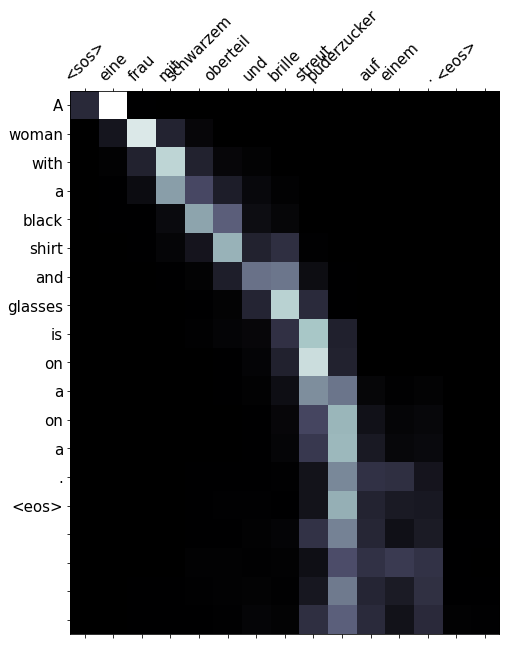

In [190]:
display_attention(
    token_transform[SOURCE_LANGUAGE](index2DEword(source)),
    token_transform[TARGET_LANGUAGE](index2ENword(translate)),
    attn
)

Translations from the training set could simply be memorized by the model. So it's only fair we look at translations from the validation and testing set too.

Starting with the test set, let's get an example.

In [84]:
test_sentences = []
for i, sent in enumerate(test_iter):
    test_sentences.append(sent)
    if i == 20:
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/datapipes/iter/combining.py:249: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  "the buffer and each child DataPipe will read from the start again.", UserWarning)


In [85]:
index = 15
source, translate, target, attn = translate_sentence(
    test_sentences[index][0], test_sentences[index][1], model, DEVICE, 50)

print(f"Source: {index2DEword(source)}")
print(f"Translation: {index2ENword(translate)}")
print(f"Target: {index2ENword(target)}")

Source: Ein Mädchen in einem läuft über einen erhöhten Schwebebalken .
Translation: A girl in a suit walks over a stone ladder .
Target: A girl in a jean dress is walking along a raised balance beam .


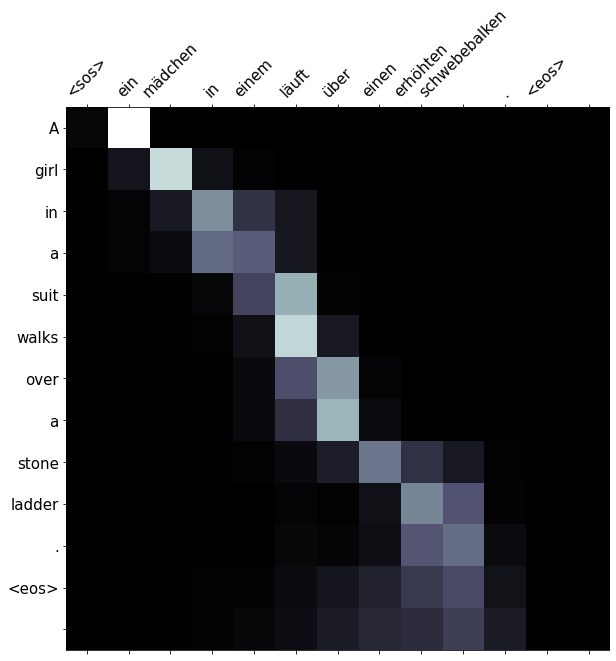

In [86]:
display_attention(
    token_transform[SOURCE_LANGUAGE](index2DEword(source)),
    token_transform[TARGET_LANGUAGE](index2ENword(translate)),
    attn
)

In [87]:
index = 10
source, translate, target, attn = translate_sentence(
    test_sentences[index][0], test_sentences[index][1], model, DEVICE, 50)

print(f"Source: {index2DEword(source)}")
print(f"Translation: {index2ENword(translate)}")
print(f"Target: {index2ENword(target)}")

Source: Eine Mutter und ihr kleiner Sohn genießen einen schönen Tag im Freien .
Translation: Mother mom and her son enjoying enjoying a beautiful day day .
Target: A mother and her young song enjoying a beautiful day outside .


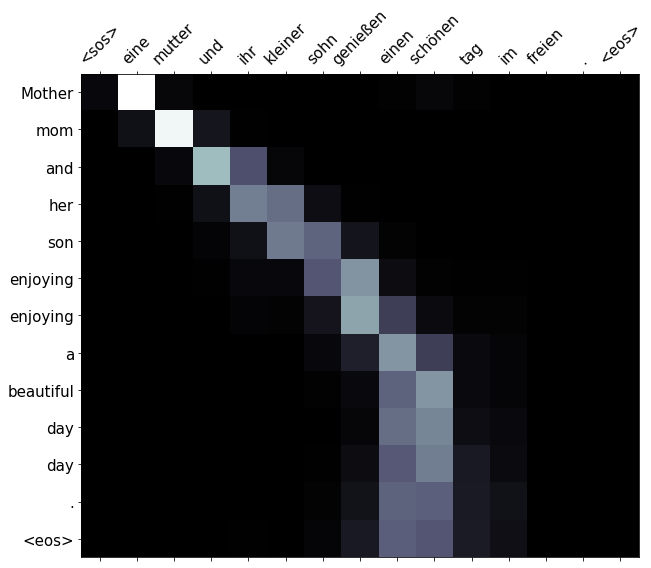

In [88]:
display_attention(
    token_transform[SOURCE_LANGUAGE](index2DEword(source)),
    token_transform[TARGET_LANGUAGE](index2ENword(translate)),
    attn
)

## BLEU

Previously we have only cared about the loss/perplexity of the model. However there metrics that are specifically designed for measuring the quality of a translation - the most popular is *BLEU*. Without going into too much detail, BLEU looks at the overlap in the predicted and actual target sequences in terms of their n-grams. It will give us a number between 0 and 1 for each sequence, where 1 means there is perfect overlap, i.e. a perfect translation, although is usually shown between 0 and 100. BLEU was designed for multiple candidate translations per source sequence, however in this dataset we only have one candidate per source.

We define a `calculate_bleu` function which calculates the BLEU score over a provided TorchText dataset. This function creates a corpus of the actual and predicted translation for each source sentence and then calculates the BLEU score.

In [139]:
def index2English(sent, target: bool = True):
    string = []
    for index in sent:
        if index == PAD_IDX:
            break
        word = idx2en[index]
        string.append(word)
    if target:
        return string
    return string[:-1]

In [179]:
from torchtext.data.metrics import bleu_score


def calculate_blue(data, model, device):
    predictions = []
    targets = []

    model.eval().to(device)
    
    for datum in data:
        output = model(datum, 0)
        for i in range(output.size(1)):
            sent = output[:, i]
            sent = sent.argmax(-1).detach().to("cpu")
            translate = index2English(sent)
            predictions.append(translate)

        for i in range(datum["target"].size(1)):
            target = datum["target"][:, i]
            sent = target.detach().to("cpu")
            translate = index2English(target)
            targets.append([translate])

    return bleu_score(predictions, targets)

We get a BLEU of around 15. If we compare it to the paper that the attention model is attempting to replicate, they achieve a BLEU score of 26.75. The original repo has achieved 28. Since the we have bigger model while the model was trained with only 10 epochs.

This number isn't really interpretable, we can't really say much about it. The most useful part of a BLEU score is that it can be used to compare different models on the same dataset, where the one with the **higher** BLEU score is "better".

In [181]:
bleu_score = calculate_blue(test_dataloader, model, DEVICE)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 14.68


In the next tutorials we will be moving away from using recurrent neural networks and start looking at other ways to construct sequence-to-sequence models. Specifically, in the next tutorial we will be using convolutional neural networks.